# This is to demonstrate a few interesting visualization amongst our aircraft dataset hierarchical structure:
## Amongst them 30 manufacturers branch out 70 families and further out to 100 variants

In [9]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio
from plotly.offline import init_notebook_mode
import os
import altair as alt
import networkx as nx

In [10]:
print(pio.renderers)

Renderers configuration
-----------------------
    Default renderer: 'vscode'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']



# Hierarchy structure of model, family and variant scraped to a dictionary

In [3]:
aircraft_hierarchy = {
 'ATR':{'ATR-42':['ATR-42'], 'ATR-72':['ATR-72']},#Fr
 'Airbus':{'A300':['A300B4'], 'A310':['A310', 'A318', 'A319'], 'A320':['A320', 'A321'], 'A330':['A330-200', 'A330-300'], 
           'A340':['A340-200', 'A340-300', 'A340-500', 'A340-600'], 'A380':['A380']},#Fr
 'Antonov':{'An-12':['An-12']},#Ru
 'Beechcraft':{'Beechcraft 1900':['Beechcraft 1900'], 'King Air':['Model B200']},#US
 'Boeing':{'Boeing 707':['707-320'], 'Boeing 717':['Boeing 717'], 'Boeing 727':['727-200'], 
           'Boeing 737':['737-200','737-300','737-400','737-500','737-600','737-700','737-800','737-900'], 
           'Boeing 747':['747-100','747-200','747-300','747-400'], 'Boeing 757':['757-200','757-300'], 'Boeing 767':['767-200','767-300','767-400'], 
           'Boeing 777':['777-200','777-300']},#US
 'Bombardier Aerospace':{'CRJ-200':['CRJ-200'], 'CRJ-700':['CRJ-700', 'CRJ-900'], 'Global Express':['Global Express']},#CA
 'British Aerospace':{'BAE 146':['BAE 146-200', 'BAE 146-300'], 'BAE-125':['BAE-125'], 'Hawk T1':['Hawk T1']},#UK
 'Canadair':{'Challenger 600':['Challenger 600']},#CA
 'Cessna':{'Cessna 172':['Cessna 172'],'Cessna 208':['Cessna 208'],'Cessna Citation':['Cessna 525', 'Cessna 560']},#US
 'Cirrus Aircraft':{'SR-20':['SR-20']},#US
 'Dassault Aviation':{'Falcon 2000':['Falcon 2000'],'Falcon 900':['Falcon 900']},#FR
 'Dornier':{'Dornier 328':['Dornier 328']},#DE
 'Douglas Aircraft Company':{'C-47':['C-47'],'DC-3':['DC-3'],'DC-6':['DC-6'],'DC-8':['DC-8'],'DC-9':['DC-9-30']},#US
 'Embraer':{'EMB-120':['EMB-120'],'Embraer E-Jet':['E-170','E-190','E-195'],'Embraer ERJ 145':['ERJ 135','ERJ 145'],
            'Embraer Legacy 600':['Embraer Legacy 600']},#BR
 'Eurofighter':{'Eurofighter Typhoon':['Eurofighter Typhoon']},#UK
 'Fairchild':{'Metroliner':['Metroliner']},#US
 'Fokker':{'Fokker 100':['Fokker 100'],'Fokker 50':['Fokker 50'],'Fokker 70':['Fokker 70']},#NE
 'Gulfstream Aerospace':{'Gulfstream':['Gulfstream IV', 'Gulfstream V']},#US
 'Ilyushin':{'Il-76':['Il-76']},#RU
 'Lockheed Corporation':{'C-130':['C-130']},#US
 'Lockheed Martin':{'F-16':['F-16A/B'], 'L-1011':['L-1011']},
 'McDonnell Douglas':{'DC-10':['DC-10'],'MD-11':['MD-11'],'MD-80':['MD-80','MD-87'],'MD-90':['MD-90'], 'F/A-18':['F/A-18']},#US
 'Panavia':{'Tornado':['Tornado']},#DE
 'Piper':{'PA-28':['PA-28']},#US
 'Robin':{'DR-400':['DR-400']},#FR
 'Saab':{'Saab 2000':['Saab 2000'], 'Saab 340':['Saab 340']},#Swe,
 'Supermarine':{'Spitfire':['Spitfire']},#UK,
 'Tupolev':{'Tu-134':['Tu-134'], 'Tu-154':['Tu-154']},#RU,
 'Yakovlev':{'Yak-42':['Yak-42']},#RU,
 'de Havilland':{'DH-82':['DH-82'],'DHC-1':['DHC-1'],'DHC-6':['DHC-6'], 'Dash 8':['DHC-8-100','DHC-8-300']}#CA
}

# Prepare required functions

In [6]:
def hierarchy_to_dataframe(hierarchy):
    data = []
    for manufacturer, families in hierarchy.items():
        for family, variants in families.items():
            for variant in variants:
                data.append([manufacturer, family, variant])
    df = pd.DataFrame(data, columns=['Manufacturer', 'Family', 'Variant'])
    manufacturer_counts = df['Manufacturer'].value_counts().reset_index()
    manufacturer_counts.columns = ['Manufacturer', 'Count']
    top_manufacturers = manufacturer_counts.nlargest(30, 'Count')['Manufacturer']
    df_top = df[df['Manufacturer'].isin(top_manufacturers)]
    return df_top

def sankey(hierarchy):
    # Extract top 30 manufacturers by number of aircraft families
    top_manufacturers = sorted(hierarchy.keys(), key=lambda k: len(hierarchy[k]), reverse=True)[:30]
    
    # Prepare data for Sankey diagram
    labels = []
    sources = []
    targets = []
    values = []
    
    # Add manufacturers to labels
    labels.extend(top_manufacturers)
    
    # Add aircraft families and model variants to labels, sources, targets, and values
    for manufacturer in top_manufacturers:
        manufacturer_index = labels.index(manufacturer)
        for family, models in hierarchy[manufacturer].items():
            if family not in labels:
                labels.append(family)
            family_index = labels.index(family)
            sources.append(manufacturer_index)
            targets.append(family_index)
            values.append(len(models))
            for model in models:
                if model not in labels:
                    labels.append(model)
                model_index = labels.index(model)
                sources.append(family_index)
                targets.append(model_index)
                values.append(1)
    return labels, sources, targets, values
    
def network(hierarchy):
    # Create a NetworkX graph
    G = nx.DiGraph()
    
    # Add nodes and edges to the graph
    for manufacturer, families in aircraft_hierarchy.items():
        G.add_node(manufacturer, size=len(families))
        for family, models in families.items():
            G.add_node(family, size=len(models))
            G.add_edge(manufacturer, family)
            for model in models:
                G.add_node(model, size=1)
                G.add_edge(family, model)
    
    top_30_manufacturers = sorted(aircraft_hierarchy.keys(), key=lambda x: len(aircraft_hierarchy[x]), reverse=True)[:30]
    
    subgraph_nodes = set()
    for manufacturer in top_30_manufacturers:
        subgraph_nodes.add(manufacturer)
        for family in aircraft_hierarchy[manufacturer].keys():
            subgraph_nodes.add(family)
            for model in aircraft_hierarchy[manufacturer][family]:
                subgraph_nodes.add(model)
    
    subgraph = G.subgraph(subgraph_nodes)
    return subgraph

# Unpack some variables for visualization to use later

In [7]:
df_top = hierarchy_to_dataframe(aircraft_hierarchy)
labels, sources, targets, values = sankey(aircraft_hierarchy)
subgraph = network(aircraft_hierarchy)

# Interactive Plotly

## Treemap

In [ ]:
fig = px.treemap(df_top, path=['Manufacturer', 'Family', 'Variant'],
                 title='Aircraft Hierarchy Treemap',
                 width=1100, height=900)

fig.update_layout(margin=dict(t=50, l=25, r=25, b=25), font=dict(size=14))

fig.write_html(os.path.join(os.pardir, "docs", "interactive_treemap.html"))
print("Interactive Treemap saved as 'interactive_treemap.html'.")
fig.show()

Interactive Treemap saved as 'interactive_treemap.html'.


## Sunburst

In [ ]:
fig = px.sunburst(df_top, path=['Manufacturer', 'Family', 'Variant'], 
                  width=1200, height=800,
                  title='Aircraft Hierarchy Sunburst Chart',
                  color_discrete_sequence=px.colors.qualitative.Pastel)

fig.update_layout(margin=dict(t=50, l=25, r=25, b=25), 
                  title_font_size=20, 
                  font=dict(size=14))
fig.write_html(os.path.join(os.pardir, "docs", "interactive_sunburst.html"))
print("Interactive Sunburst saved as 'interactive_sunburst.html'.")
fig.show()

Interactive Sunburst saved as 'interactive_sunburst.html'.


## Icicle 

In [ ]:
fig = px.icicle(df_top, path=['Manufacturer', 'Family', 'Variant'], width=1200, height=800)
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25), font=dict(size=14))
fig.write_html(os.path.join(os.pardir, "docs", "interactive_icicle.html"))
print("Interactive Icicle saved as 'interactive_icicle.html'.")
fig.show()

Interactive Icicle saved as 'interactive_icicle.html'.


## Sankey diagram

In [ ]:
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="blue"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
)])

fig.update_layout(title_text="Aircraft Hierarchy Sankey Diagram", font_size=10, width=1200, height=800)
fig.write_html(os.path.join(os.pardir, "docs", "interactive_sankey.html"))
print("Interactive Sankey saved as 'interactive_sankey.html'.")
fig.show()


Interactive Sankey saved as 'interactive_sankey.html'.


# Altair

## Layered Bar plot

In [ ]:
alt.Chart(df_top).mark_bar().encode(
    alt.X('count(Variant):Q', axis=alt.Axis(title='Number of Models')),
    alt.Y('Manufacturer:N', axis=alt.Axis(title='Manufacturer')),
    color='Family:N',
    tooltip=['Manufacturer', 'Family', 'Variant']
).properties(
    width=800,
    height=600,
    title='Aircraft Hierarchy Layered Bar Plot'
).interactive()#.save(os.path.join(os.pardir, "docs", "aircraft_barplot.html"))

alt.Chart(...)

## Radial plot

In [ ]:
alt.Chart(df_top).mark_arc().encode(
    alt.Theta('Family:N', stack=True),
    alt.Radius('count(Variant):Q', scale=alt.Scale(type='sqrt')),
    color='Manufacturer:N',
    tooltip=['Manufacturer', 'Family', 'Variant']
).properties(
    width=1000,
    height=800,
    title='Aircraft Hierarchy Radial Plot'
).interactive()#.save(os.path.join(os.pardir, "docs", "aircraft_radialplot.html"))

alt.Chart(...)

## Tree plot

In [14]:
alt.Chart(df_top).mark_point().encode(
    alt.X('Manufacturer:N', axis=alt.Axis(title='Manufacturer')),
    alt.Y('Family:N', axis=alt.Axis(title='Family')),
    color='Manufacturer:N',
    size='count(Variant):Q',
    tooltip=['Manufacturer', 'Family', 'Variant']
).properties(
    width=800,
    height=1200,
    title='Aircraft Hierarchy Tree Plot'
).display()


alt.Chart(...)

# NetworkX

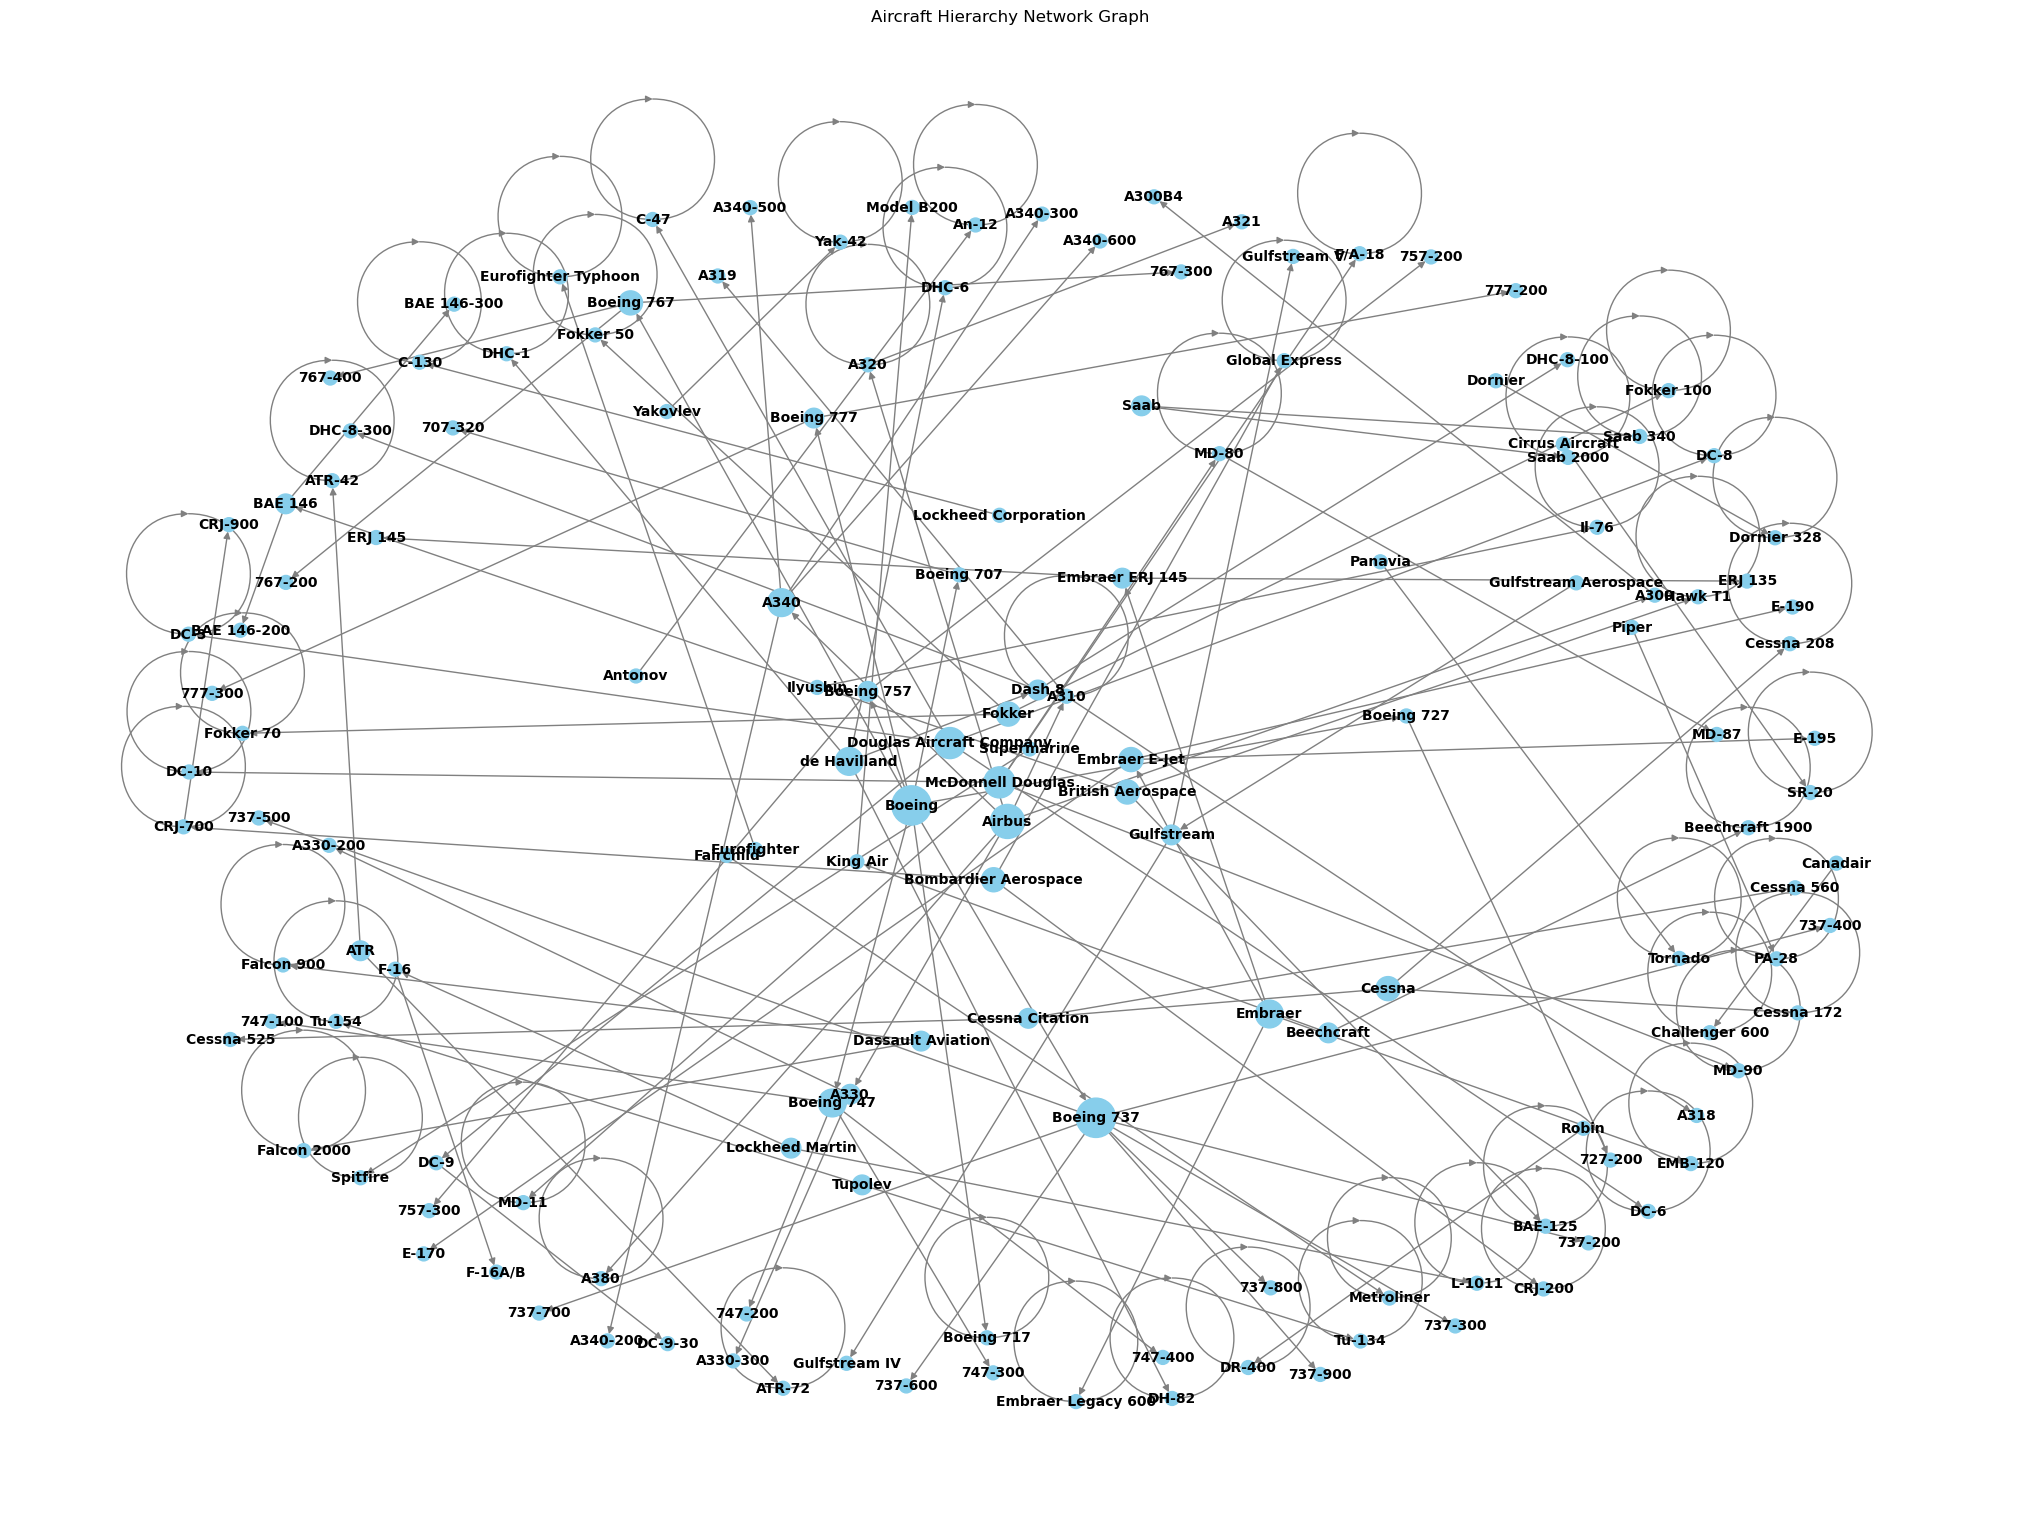

In [15]:
plt.figure(figsize=(20, 15))
pos = nx.spring_layout(subgraph, k=0.5, iterations=50)
nx.draw(subgraph, pos, with_labels=True, node_size=[subgraph.nodes[n]['size']*100 for n in subgraph.nodes], 
        node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
plt.title('Aircraft Hierarchy Network Graph');